In [ ]:
import os
import glob
from datetime import datetime

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image

import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

from sklearn.metrics import confusion_matrix

!pip install exif
from exif import Image as exif

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.5 MB/s 
Mounted at /content/gdrive


In [ ]:
model_path = '/content/gdrive/MyDrive/Colab Notebooks/Training_Log/' + 'Zephyr' + '/epoch_16_2022-08-30 08:29:33.518457.pt'

In [ ]:
label_dict = {
    'Aglaonema_commutatum': 0,
     'Asplenium_nidus': 1,
     'Calathea_orbifolia': 2,
     'Chamaedorea_elegans': 3,
     'Dracaena_reflexa': 4,
     'Dracaena_trifasciata': 5,
     'Dypsis_lutescens': 6,
     'Epipremnum_aureum': 7,
     'Hoya_carnosa': 8,
     'Maranta_leuconeura': 9,
     'Monstera_deliciosa': 10,
     'Nephrolepis_cordifolia': 11,
     'Pachira_aquatica': 12,
     'Peperomia_argyreia': 13,
     'Peperomia_obtusifolia': 14,
     'Philodendron_gloriosum': 15,
     'Rhapis_excelsa': 16,
     'Schefflera_arboricola': 17,
     'Tradescantia_zebrina': 18,
     'Zamioculcas': 19
}

In [ ]:
label_list = [k for k in label_dict]
label_list

['Aglaonema_commutatum',
 'Asplenium_nidus',
 'Calathea_orbifolia',
 'Chamaedorea_elegans',
 'Dracaena_reflexa',
 'Dracaena_trifasciata',
 'Dypsis_lutescens',
 'Epipremnum_aureum',
 'Hoya_carnosa',
 'Maranta_leuconeura',
 'Monstera_deliciosa',
 'Nephrolepis_cordifolia',
 'Pachira_aquatica',
 'Peperomia_argyreia',
 'Peperomia_obtusifolia',
 'Philodendron_gloriosum',
 'Rhapis_excelsa',
 'Schefflera_arboricola',
 'Tradescantia_zebrina',
 'Zamioculcas']

## Dataset

In [ ]:
class GreenFingerDataset(Dataset):

    def __init__(self, data_path, label_dict, oversample=False, transforms=None, rotate=False):
        # retrieve jpg file path from directory: training/validation/testing
        self.files = sorted(glob.glob(os.path.join(data_path, "*.jpg")))
        # convert jpg file path to dataframe and attach true label
        self.df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in self.files],
                image_path=self.files
            )
        )
        # copy dataframe
        self.df_oversampled = self.df.copy()
        # process oversample function
        if oversample:
            self.oversample()
        # initialize transform procedure
        self.transforms = transforms
        # initialize true label numbering
        self.label_dict = label_dict
        self.rotate = rotate

    def oversample(self):
        """
        This functions can be called or 
        initialized automatically when the oversample=True
        """
        # Random sampling til the # of sample matches to the # of largest category
        cats = self.df.cat.drop_duplicates().to_numpy()
        cat_sizes = []

        for c in cats:
            n = len(self.df.query(f"cat == '{c}'"))
            cat_sizes.append(n)

        cat_sizes = np.array(cat_sizes)
        dfs = []
        n_majority = np.max(cat_sizes)

        for i, c in enumerate(cats):
            df_cat = self.df.query(f"cat == '{c}'").sample(frac=n_majority/cat_sizes[i], replace=True)
            dfs.append(df_cat)

        self.df_oversampled = pd.concat(dfs, axis=0).reset_index(drop=True)

    def __len__(self):
        return len(self.df_oversampled)

    def __getitem__(self, idx):
        img_src, cat = self.df_oversampled.iloc[idx][["image_path", "cat"]]
        # What's the difference between torchvision's readimage and PIL's Image.open?
        x = Image.open(img_src)
        
        if self.rotate:
            with open(img_src, "rb") as f:
                img_exif = exif(f)

            if int(img_exif.orientation) == 6:
                x = x.rotate(-90)
        
        # x = read_image(img_src)
        if self.transforms:
            x = self.transforms(x)
        x = x.float()
        if len(x.size()) == 2:
            # when it's multi channels, x.size() shows (Channel, Heigh, Weight)
            # when channel is 1, x.size() shows (Heigh, Weight) w/o channel
            x = x.unsqueeze(0) 
            x = torch.cat((x, x, x), axis=0)
        if cat in self.label_dict:
            y = self.label_dict[cat]
        else:
            y= -1
        y = torch.Tensor([y]).long()
        
        return x, y

In [ ]:
# Transform for Validation Dataset
transforms_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(256), # unify all image as square shape
        transforms.Normalize( # tied with pre-trained weights
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

transforms_val

Compose(
    ToTensor()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(256, 256))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
# Validation Dataset
path_sample_not_in_20_class = '/content/gdrive/MyDrive/Colab Notebooks/' + 'Merged_code/Not_in_class/'
# ds_val = GreenFingerDataset(
#     "datasets/rodrigues",
#     label_dict,
#     transforms=transforms_val
# )

ds_val = GreenFingerDataset(
    path_sample_not_in_20_class,
    label_dict,
    transforms=transforms_val
)
print("ds_val", len(ds_val))

ds_val 9


## Network

In [ ]:
n_class = 20

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model.fc = nn.Linear(model.fc.in_features, n_class)
# model

In [ ]:
model.load_state_dict(torch.load(model_path, map_location="cpu")["model_state_dict"])

<All keys matched successfully>

## Inference

CPU: 5.69 iters / s

M1: 6.06 iters / s

In [ ]:
batch_size = 4

dl_val = DataLoader(
    ds_val,
    shuffle=False,
    batch_size=batch_size,
    drop_last=False,
)

In [ ]:
model.eval()

predictions = []

device = torch.device("cpu")
# device = torch.device("mps")

model = model.to(device)

with torch.no_grad():
    for (x, y) in tqdm(dl_val, desc='Validation', position=0, leave=True):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        # To-Do: Optimize Prediction & Accuracy?
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    probs = np.concatenate(predictions, axis=0)
    probs = np.exp(probs)
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    preds = np.argmax(probs, axis=1)
    y = np.concatenate([item[1].numpy() for item in ds_val])

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

probs

array([[8.66273302e-04, 7.99435482e-04, 5.85339963e-04, 1.10949879e-03,
        9.53670621e-01, 2.24722065e-02, 1.29367469e-03, 5.69206383e-03,
        2.00550724e-03, 7.07504631e-04, 1.45685088e-04, 6.35131379e-04,
        4.25180979e-03, 6.96239818e-04, 4.14655951e-04, 1.06228552e-04,
        1.75266978e-04, 4.09760309e-04, 2.65589915e-03, 1.30726106e-03],
       [7.49742205e-04, 1.01816487e-02, 1.02676882e-03, 1.03607017e-03,
        3.34413198e-04, 8.15952139e-04, 1.00262696e-04, 7.70586729e-01,
        1.96709465e-02, 4.28805040e-04, 4.63316664e-02, 9.32820840e-04,
        5.50071783e-02, 3.71462782e-04, 4.55123984e-04, 4.88578342e-04,
        2.72134290e-04, 8.18850026e-02, 3.15388711e-03, 6.17084838e-03],
       [2.60494344e-05, 1.25708038e-05, 2.74715057e-05, 7.85823977e-06,
        8.94959976e-06, 1.93424148e-05, 5.16571845e-06, 9.70121324e-01,
        7.90173362e-05, 8.86522321e-06, 1.03482298e-05, 3.68823348e-05,
        3.22094158e-04, 7.82725692e-06, 3.05760477e-04, 8.9629

In [ ]:
preds

array([ 4,  7,  7,  7,  7, 17,  7, 13,  8])

In [ ]:
# Initialize transform proceduce for visualizing images
transforms_val_for_viz = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            256,
            interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.CenterCrop(256),
    ]
)

ds_val_for_viz = GreenFingerDataset(
    path_sample_not_in_20_class,
    label_dict,
    rotate=True,
    transforms=transforms_val_for_viz
)
print("ds_val_for_viz", len(ds_val_for_viz))

ds_val_for_viz 9


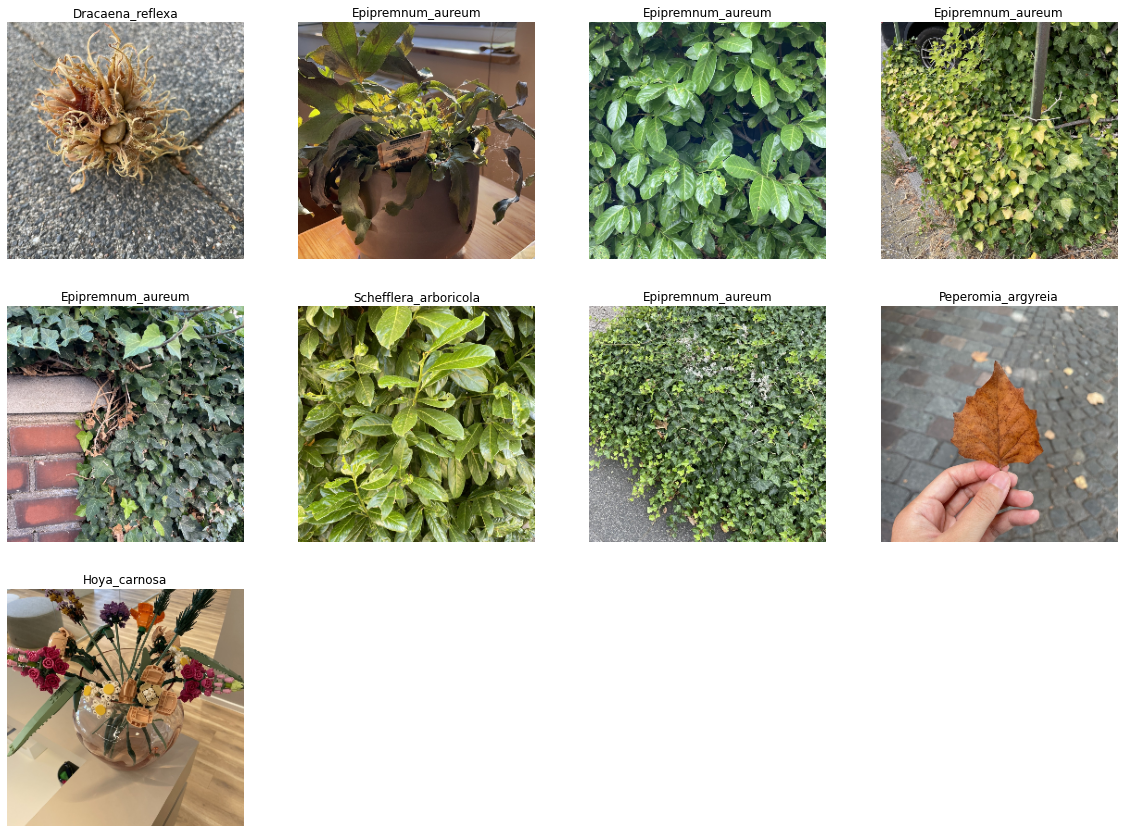

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.patch.set_alpha(1.0)
for i in range(len(ds_val_for_viz)):
    x, y = ds_val_for_viz[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(torch.permute(x, [1, 2, 0]))
    plt.axis("off")
    plt.title(label_list[preds[i]])
plt.savefig("rodrigues.png")

## Prob analysis

(0.0, 1.0)

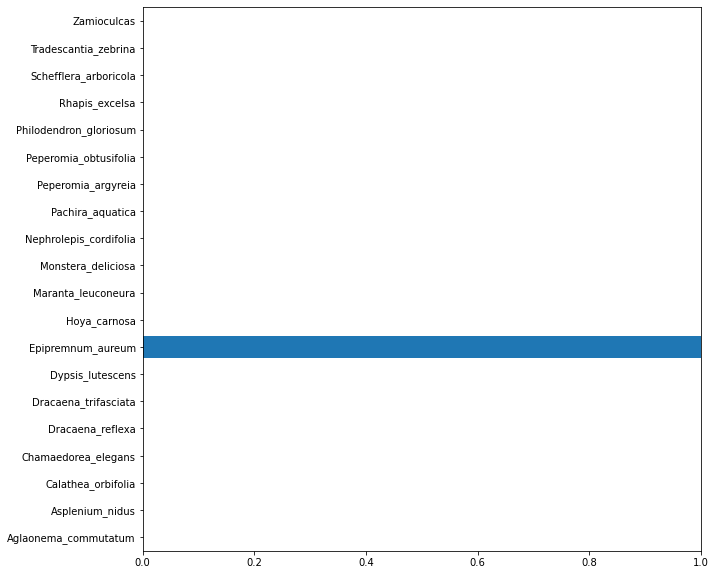

In [ ]:
idx = 4


fig = plt.figure(figsize=(10, 10))
plt.barh(np.arange(n_class), probs[idx])
plt.yticks(np.arange(n_class), label_list)
plt.ylim([-0.5, 19.5])
plt.xlim([0.0, 1.0])

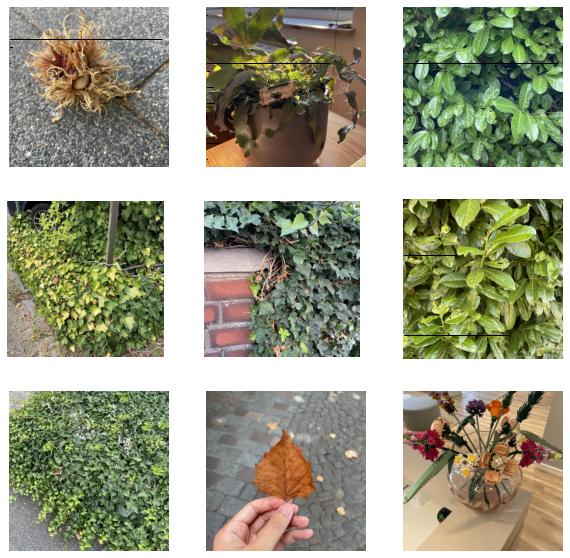

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    x, y = ds_val_for_viz[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(np.transpose(x, [1, 2, 0]))
    plt.axis("off")
    ax = plt.barh(np.arange(n_class)*256/20, 256*probs[i], facecolor="k")
#     ax.patches[0].set_alpha(0.5)
#     plt.yticks(np.arange(n_class), label_list)
#     plt.ylim([-0.5, 19.5])
#     plt.xlim([0.0, 1.0])

In [ ]:
# cols = 3
# rows = 3
# fig, axs = plt.subplots(cols, rows, figsize=(9, 9))

# i = 0
# for col in range(cols):
#     for row in range(rows):
#         x, y = ds_val_for_viz[i]
#         axs[row, col].imshow(np.transpose(x, [1, 2, 0]))
#         axs[row, col].axis("off")
#         axs[row, col].barh(np.arange(n_class)*256/20, 256*probs[i], facecolor="k")
#         i +=1


## Top-k analysis

In [ ]:
labels = [ 7,  7, 10, 10,  7,  5,  -1,  -1, -1, -1,  5,  -1, 10,  10,  7,  5]
labels

[-1, -1, -1, -1, -1, -1, -1, -1, -1]

In [ ]:
idxs = np.argsort(probs, axis=1)

np.sum(labels == idxs[:, -1]) 

10

In [ ]:
np.sum(labels == idxs[:, -2])

1

## EXIF

http://sylvana.net/jpegcrop/exif_orientation.html

In [ ]:
with open("datasets/rodrigues/unknown/IMG_0611.JPG", "rb") as f:
    img_exif = exif(f)

In [ ]:
int(img_exif.orientation)

6